[Reference for the Below Analysis](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Time Series Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_excel('../Data/monthly_data_total.xlsx')
df.head()

,Date,Import,Export
0,2006-01-01,12519.71,9143.66
1,2006-02-01,11479.69,8993.29
2,2006-03-01,14314.02,11560.97
3,2006-04-01,12924.18,8624.66
4,2006-05-01,15105.67,10109.30


In [4]:
df.index = df.Date

In [5]:
df.drop('Date', axis =1, inplace = True)

In [6]:
df.head()

,Import,Export
Date,,
2006-01-01,12519.71,9143.66
2006-02-01,11479.69,8993.29
2006-03-01,14314.02,11560.97
2006-04-01,12924.18,8624.66
2006-05-01,15105.67,10109.30


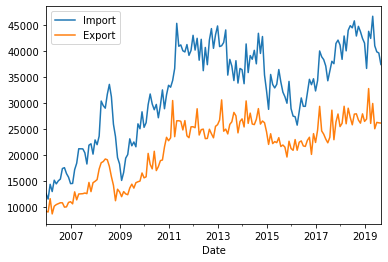

In [7]:
df.plot()

In [0]:
df['exp_import'] = np.log(df['Import'])
df['exp_export'] = np.log(df['Export'])

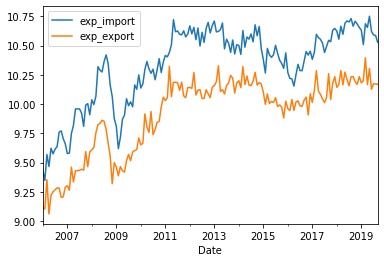

In [9]:
df[['exp_import','exp_export']].plot()

Checking if the data is stationary or not esle we will first make it stationary

In [0]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)



In [11]:
adf_test(df['Import'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.299031
p-value                          0.172281
#Lags Used                       1.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


In [13]:
adf_test(df['Export'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.996100
p-value                          0.288286
#Lags Used                      12.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [14]:
#apply adf test on the series
adf_test(df['exp_import'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.943212
p-value                          0.040549
#Lags Used                       1.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


In [15]:
adf_test(df['exp_export'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.234790
p-value                          0.193862
#Lags Used                      12.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


 If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary)

 In our case, our series is stationary with the 5% confidence interval.

In [0]:
df_test = df[-12:]
df_test

,Import,Export,exp_import,exp_export
Date,,,,
2018-10-01,44677.50,26673.52,10.707225,10.191427
2018-11-01,43654.80,26071.13,10.684069,10.168584
2018-12-01,42350.63,27857.86,10.653739,10.234870
2019-01-01,41454.91,26408.97,10.632362,10.181459
2019-02-01,36590.02,26865.68,10.507531,10.198605
2019-03-01,43718.65,32717.30,10.685530,10.395659
2019-04-01,42361.61,26023.18,10.653998,10.166743
2019-05-01,46618.80,29854.24,10.749759,10.304082
2019-06-01,40941.24,24990.77,10.619893,10.126262


In [0]:
df_train = df[: -12]
df_train

,Import,Export,exp_import,exp_export
Date,,,,
2006-01-01,12519.71,9143.66,9.435059,9.120816
2006-02-01,11479.69,8993.29,9.348335,9.104234
2006-03-01,14314.02,11560.97,9.568995,9.355390
2006-04-01,12924.18,8624.66,9.466855,9.062381
2006-05-01,15105.67,10109.30,9.622825,9.221211
...,...,...,...,...
2018-05-01,43916.88,28944.54,10.690054,10.273137
2018-06-01,44806.20,27157.65,10.710102,10.209414
2018-07-01,44387.68,25753.80,10.700717,10.156337


In [0]:
def rmse(predictions, targets): 

  return np.sqrt(((predictions - targets) ** 2).mean())

## AR (Autoregression)

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregression model.

The method is suitable for univariate time series without trend and seasonal components.

In [0]:
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
# fit model
model = AR(df_train['exp_import'])
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(df_train), len(df_train)+11)
model2 = AR(df_train['exp_export'])
model2_fit = model2.fit()
# make prediction
yhat2 = model2_fit.predict(len(df_train), len(df_train)+11)
df_test['AR_import'] = np.exp(yhat)
df_test['AR_export'] = np.exp(yhat2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [0]:
rmse(df_test.Import.values, df_test.AR_import.values), rmse(df_test.Export.values, df_test.AR_export.values)

(2783.683284310495, 2024.224805362463)

In [0]:
df_test[['Import','AR_import', 'Export', 'AR_export']]

,Import,AR_import,Export,AR_export
Date,,,,
2018-10-01,44677.50,42057.101661,26673.52,25035.718001
2018-11-01,43654.80,41847.627691,26071.13,27199.557251
2018-12-01,42350.63,41193.046004,27857.86,27013.247703
2019-01-01,41454.91,41096.804223,26408.97,25174.985346
2019-02-01,36590.02,39849.176014,26865.68,26611.630563
2019-03-01,43718.65,40496.613097,32717.30,27079.473334
2019-04-01,42361.61,39418.567440,26023.18,24815.496511
2019-05-01,46618.80,39895.651173,29854.24,27310.329976
2019-06-01,40941.24,39859.234594,24990.77,26210.059706


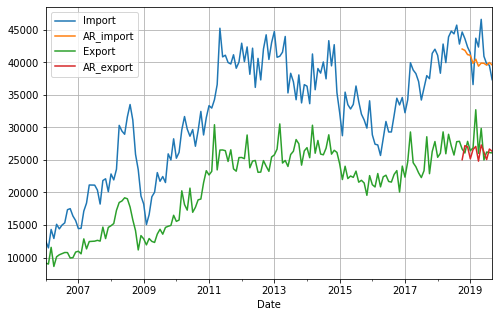

In [0]:
df['AR_import'] = df_test['AR_import']
df['AR_export'] = df_test['AR_export']
df[['Import','AR_import', 'Export', 'AR_export']].plot(figsize = (8,5), grid = True)


## MA (Moving Average)

The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.

A moving average model is different from calculating the moving average of the time series.

The notation for the model involves specifying the order of the model q as a parameter to the MA function, e.g. MA(q). For example, MA(1) is a first-order moving average model.

The method is suitable for univariate time series without trend and seasonal components.

In [0]:
# We can use the ARMA class to create an MA model and setting a zeroth-order AR model. We must specify the order of the MA model in the order argument.

# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# fit model import
model = ARMA(df_train['exp_import'], order=(0, 12))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(df_train), len(df_train)+ 11)

# fit model export
model2 = ARMA(df_train['exp_export'], order=(0, 12))
model2_fit = model2.fit(disp=False)
# make prediction
yhat2 = model2_fit.predict(len(df_train), len(df_train)+ 11)

df_test['MA_import'] = np.exp(yhat)
df_test['MA_export'] = np.exp(yhat2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: ignored

In [0]:
rmse(df_test.Import.values, df_test.MA_import.values), rmse(df_test.Export.values, df_test.MA_export.values)

In [0]:
df_test[['Import','MA_import', 'Export', 'MA_export']]

In [0]:
df['MA_import'] = df_test['MA_import']
df['MA_export'] = df_test['MA_export']
df[['Import','MA_import', 'Export', 'MA_export']].plot(figsize = (8,5), grid = True)


## ARMA (Autoregresive Moving Average)

The Autoregressive Moving Average (ARMA) method models the next step in the sequence as a linear function of the observations and resiudal errors at prior time steps.

It combines both Autoregression (AR) and Moving Average (MA) models.

The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to an ARMA function, e.g. ARMA(p, q). An ARIMA model can be used to develop AR or MA models.

The method is suitable for univariate time series without trend and seasonal components.

In [0]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# fit model
model = ARMA(df_train['exp_import'], order=(2, 12))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(df_train), len(df_train)+11)

# fit model
model2 = ARMA(df_train['exp_export'], order=(2, 12))
model2_fit = model2.fit(disp=False)
# make prediction
yhat2 = model2_fit.predict(len(df_train), len(df_train)+11)

df_test['ARMA_import'] = np.exp(yhat)
df_test['ARMA_export'] = np.exp(yhat2)

In [0]:
rmse(df_test.Import.values, df_test.ARMA_import.values), rmse(df_test.Export.values, df_test.ARMA_export.values)

In [0]:
df_test[['Import','ARMA_import', 'Export', 'ARMA_export']]

In [0]:
df['ARMA_import'] = df_test['ARMA_import']
df['ARMA_export'] = df_test['ARMA_export']
df[['Import','ARMA_import', 'Export', 'ARMA_export']].plot(figsize = (8,5), grid = True)


In [0]:

# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)
